In [1]:
from haversine import haversine_vector
import pandas as pd
import numpy as np
import glob
import os
import sys
sys.path.append('../resources/library')
from tropical_cyclone.georeferencing import round_to_grid
from tropical_cyclone.cyclone import init_track_dataframe, tracking_algorithm, track_matching
from tropical_cyclone.visualize import plot_tracks

import warnings
warnings.filterwarnings('ignore')

/Users/davide/anaconda3/envs/mlenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# select the model to analyze
selected_model = '02_swin_msl_vo_850'
# selected_model = '03_vgg_v3_relu_ks3_msl_vo_850'
# define inference directory to draw detections
dataset_dir = '../data/inference'
# get ibtracs directory
ibtracs_src = '../data/ibtracs/filtered/ibtracs_main-tracks_6h_1980-2021_TS-NR-ET-MX-SS-DS.csv'
# define test years (same as paper)
test_years = [1983, 1984, 1993, 1994, 2003, 2004, 2013, 2014]
# test_years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
# test_years = [1993]
# kilometer threshold
max_distance = 1000.0

In [3]:
# get model directory
model_dir = os.path.join(dataset_dir, selected_model)
# get inference filenames
inference_files =sorted(glob.glob(os.path.join(model_dir,'*.csv')))
model_dir, inference_files

('../data/inference/02_swin_msl_vo_850',
 ['../data/inference/02_swin_msl_vo_850/1983.csv',
  '../data/inference/02_swin_msl_vo_850/1984.csv',
  '../data/inference/02_swin_msl_vo_850/1993.csv',
  '../data/inference/02_swin_msl_vo_850/1994.csv',
  '../data/inference/02_swin_msl_vo_850/2003.csv',
  '../data/inference/02_swin_msl_vo_850/2004.csv',
  '../data/inference/02_swin_msl_vo_850/2013.csv',
  '../data/inference/02_swin_msl_vo_850/2014.csv'])

In [4]:
# load csv files
csv_files = []
for file in inference_files:
    csv_files.append(pd.read_csv(file, index_col=0))
# merge csv files together
detections = pd.concat(csv_files).reset_index(drop=True)
# convert iso time with pandas
detections['ISO_TIME'] = pd.to_datetime(detections['ISO_TIME'])
# add WS as np.inf
detections['WS'] = np.inf
detections

,ISO_TIME,LAT,LON,WS
0,1983-05-21 00:00:00,63.00,108.50,inf
1,1983-05-21 00:00:00,53.75,115.25,inf
2,1983-05-21 00:00:00,56.25,188.75,inf
3,1983-05-21 00:00:00,54.50,250.50,inf
4,1983-05-21 00:00:00,32.50,207.25,inf
...,...,...,...,...
72747,2014-12-31 18:00:00,54.50,163.00,inf
72748,2014-12-31 18:00:00,40.00,140.25,inf
72749,2014-12-31 18:00:00,28.00,204.25,inf
72750,2014-12-31 18:00:00,1.75,170.50,inf


In [5]:
columns = ['ISO_TIME','SID','NATURE','WMO_WIND','LAT','LON']
# load ibtracs
observations = pd.read_csv(ibtracs_src, index_col=0)
# convert iso time with pandas
observations['ISO_TIME'] = pd.to_datetime(observations['ISO_TIME'])
# get only some columns from ibtracs
observations = observations[columns]
# round lat and lon to be comparable with training data
observations['LAT'] = round_to_grid(observations['LAT'], grid_res=0.25)
observations['LON'] = round_to_grid(observations['LON'], grid_res=0.25)
observations

,ISO_TIME,SID,NATURE,WMO_WIND,LAT,LON
0,1980-03-16 00:00:00,1980076N06148,NR,,6.00,147.75
1,1980-03-16 06:00:00,1980076N06148,NR,,6.00,147.25
2,1980-03-16 12:00:00,1980076N06148,NR,,6.00,146.75
3,1980-03-16 18:00:00,1980076N06148,NR,,6.00,146.50
4,1980-03-17 00:00:00,1980076N06148,NR,,6.00,146.00
...,...,...,...,...,...,...
86188,2021-12-16 06:00:00,2021349N05108,TS,,4.50,105.00
86189,2021-12-16 12:00:00,2021349N05108,TS,,4.25,104.50
86190,2021-12-16 18:00:00,2021349N05108,TS,,4.25,103.00
86191,2021-12-17 00:00:00,2021349N05108,TS,,4.25,103.00


In [6]:
tmp = pd.merge(left=detections, right=observations, on='ISO_TIME', how='inner')
tmp = tmp[tmp['ISO_TIME'].dt.year.isin(test_years)]
dates = tmp['ISO_TIME'].to_numpy()

In [7]:
print(f'There are {len(observations)} observations and {len(detections)} detections')

There are 86193 observations and 72752 detections


In [8]:
# get only detections and observations present on both dataframes
detections = detections[detections['ISO_TIME'].isin(dates)].reset_index(drop=True)
observations = observations[observations['ISO_TIME'].isin(dates)].reset_index(drop=True)

# select only TCs belonging to a certain nature
# observations = observations[observations['NATURE'].isin(['TS','SS','ET'])]

In [9]:
print(f'There are {len(observations)} observations and {len(detections)} detections')

There are 16720 observations and 72740 detections


# Localization

In [10]:
# merge together detections and ibtracs
matches = pd.merge(left=detections, right=observations, on='ISO_TIME')
# compute haversine distance between any couple of points
matches['HDIST'] = haversine_vector(array1=matches[['LAT_x','LON_x']].to_numpy(), array2=matches[['LAT_y','LON_y']].to_numpy(), normalize=True)
matches.head()

,ISO_TIME,LAT_x,LON_x,WS,SID,NATURE,WMO_WIND,LAT_y,LON_y,HDIST
0,1983-05-21,63.00,108.50,inf,1983141N07269,TS,25,7.0,268.5,12048.150580
1,1983-05-21,53.75,115.25,inf,1983141N07269,TS,25,7.0,268.5,12809.891980
2,1983-05-21,56.25,188.75,inf,1983141N07269,TS,25,7.0,268.5,8728.254858
3,1983-05-21,54.50,250.50,inf,1983141N07269,TS,25,7.0,268.5,5521.459801
4,1983-05-21,32.50,207.25,inf,1983141N07269,TS,25,7.0,268.5,6903.854744


In [11]:
# remove all the distances above 300 km
matches = matches[matches['HDIST'] < max_distance]
# group by LATx and LONx and find the minimum (to remove x duplicates)
matches = matches.groupby(by=['ISO_TIME','LAT_x','LON_x','SID','NATURE','WMO_WIND']).min('HDIST').reset_index()
# repeat grouping by LATy and LONy and find the minimum (to remove y duplicates)
matches = matches.groupby(by=['ISO_TIME','LAT_y','LON_y','SID','NATURE','WMO_WIND']).min('HDIST')
# reset the index
matches = matches.reset_index()
# show result
matches

,ISO_TIME,LAT_y,LON_y,SID,NATURE,WMO_WIND,LAT_x,LON_x,WS,HDIST
0,1983-05-21 00:00:00,7.00,268.50,1983141N07269,TS,25,7.50,267.75,inf,99.675565
1,1983-05-21 12:00:00,7.75,266.25,1983141N07269,TS,30,8.50,265.75,inf,99.921169
2,1983-05-21 18:00:00,8.00,265.25,1983141N07269,TS,40,7.00,265.00,inf,114.559729
3,1983-05-22 00:00:00,8.50,264.50,1983141N07269,TS,45,8.25,265.50,inf,113.467129
4,1983-05-22 06:00:00,8.75,263.25,1983141N07269,TS,45,9.75,266.50,inf,373.609364
...,...,...,...,...,...,...,...,...,...,...
14447,2014-12-30 00:00:00,10.00,123.00,2014362N07130,TS,35,12.00,124.50,inf,276.154324
14448,2014-12-30 06:00:00,9.75,122.50,2014362N07130,TS,35,11.25,123.50,inf,199.431050
14449,2014-12-30 12:00:00,9.75,122.00,2014362N07130,TS,,9.00,120.25,inf,160.240037
14450,2014-12-30 18:00:00,9.25,122.00,2014362N07130,TS,,9.75,121.75,inf,61.990338


In [12]:
print(f"Model {selected_model} Localization results")
print(f"   Min distance ({np.round(matches['HDIST'].min(),2)} km)")
print(f"   Max distance ({np.round(matches['HDIST'].max(),2)} km)")
print(f"   Average distance ({np.round(matches['HDIST'].mean(),2)} km)")
print(f"   Median distance ({np.round(matches['HDIST'].median(),2)} km)")

Model 02_swin_msl_vo_850 Localization results
   Min distance (0.0 km)
   Max distance (999.54 km)
   Average distance (135.31 km)
   Median distance (80.17 km)


In [13]:
# plot_detections(detections, observations)

# Classification

In [14]:
def F_beta(beta, precision, recall):
    return (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))

In [15]:
n_dets = len(detections)
n_tp = len(matches)
n_obs = len(observations)
n_fp = n_dets - n_tp
n_fn = n_obs - n_tp

In [16]:
precision = n_tp / (n_tp + n_fp)
recall = n_tp / (n_tp + n_fn)
f2_score = F_beta(beta=2, precision=precision, recall=recall) * 100

In [17]:
print(f"Model {selected_model} Classification results")
print(f"   F2 : {np.round(f2_score,2)} % (precision={np.round(precision, 2)}, recall={np.round(recall,2)})")
print(f"   TP : {n_tp} out of {n_obs} observations ({np.round(n_tp / n_obs * 100)} %)")
print(f"   FP : {n_fp} out of {n_dets} ML detections ({np.round((n_dets - n_tp) / n_dets * 100)} %)")
print(f"   FN : {n_fn} out of {n_obs} observations ({np.round((n_obs - n_tp) / n_obs * 100)} %)")

Model 02_swin_msl_vo_850 Classification results
   F2 : 51.75 % (precision=0.2, recall=0.86)
   TP : 14452 out of 16720 observations (86.0 %)
   FP : 58288 out of 72740 ML detections (80.0 %)
   FN : 2268 out of 16720 observations (14.0 %)


# Tracking

In [18]:
# minimum track length (1 day)
min_track_count = 12
# maximum distance (in km) between each consecutive tc
max_distance = 400.0
# minimum speed of wind in order to consider the track true
min_wind_speed = 17.0
# maximum distance between matches between tracks
max_track_distance = 300.0

grid_res = 0.25
km_to_deg = 110.474

# whether or not to plot the tracks
plot = True

In [19]:
# rename SID to TRACK_ID
observed_tracks = observations.rename(columns={'SID':'TRACK_ID'})
# get only long enough tracks for the comparison
valid_observations_sids = observed_tracks.groupby('TRACK_ID').filter(lambda x: len(x) >= min_track_count)['TRACK_ID'].unique()
# filter out the observations
observed_tracks = observed_tracks[observed_tracks['TRACK_ID'].isin(valid_observations_sids)].reset_index(drop=True)
observed_tracks.head()

,ISO_TIME,TRACK_ID,NATURE,WMO_WIND,LAT,LON
0,1983-05-21 00:00:00,1983141N07269,TS,25,7.00,268.50
1,1983-05-21 06:00:00,1983141N07269,TS,25,7.50,267.25
2,1983-05-21 12:00:00,1983141N07269,TS,30,7.75,266.25
3,1983-05-21 18:00:00,1983141N07269,TS,40,8.00,265.25
4,1983-05-22 00:00:00,1983141N07269,TS,45,8.50,264.50


In [20]:
detected_tracks = init_track_dataframe(detections)
detected_tracks = tracking_algorithm(detected_tracks, max_distance, min_track_count)
detected_tracks.head()

,ISO_TIME,LAT,LON,WS,TRACK_ID,HAVERSINE
0,1983-05-21 18:00:00,52.25,264.00,inf,19830521T18_1,260.457235
1,1983-05-22 00:00:00,53.25,267.50,inf,19830521T18_1,195.271874
2,1983-05-22 06:00:00,55.00,267.75,inf,19830521T18_1,334.991215
3,1983-05-22 12:00:00,58.00,268.25,inf,19830521T18_1,240.306499
4,1983-05-22 18:00:00,59.50,271.25,inf,19830521T18_1,331.785985


In [21]:
# paper_detected_tracks = init_track_dataframe(detections)
# paper_detected_tracks = paper_tracking_algorithm(paper_detected_tracks, max_distance, min_track_count)
# paper_detected_tracks.head()

In [22]:
print(f'There are:')
print(f'   - {len(detected_tracks["TRACK_ID"].unique())} detected tracks')
# print(f'   - {len(paper_detected_tracks["TRACK_ID"].unique())} detected tracks (paper)')
print(f'   - {len(observed_tracks["TRACK_ID"].unique())} observed tracks')

There are:
   - 554 detected tracks
   - 459 observed tracks


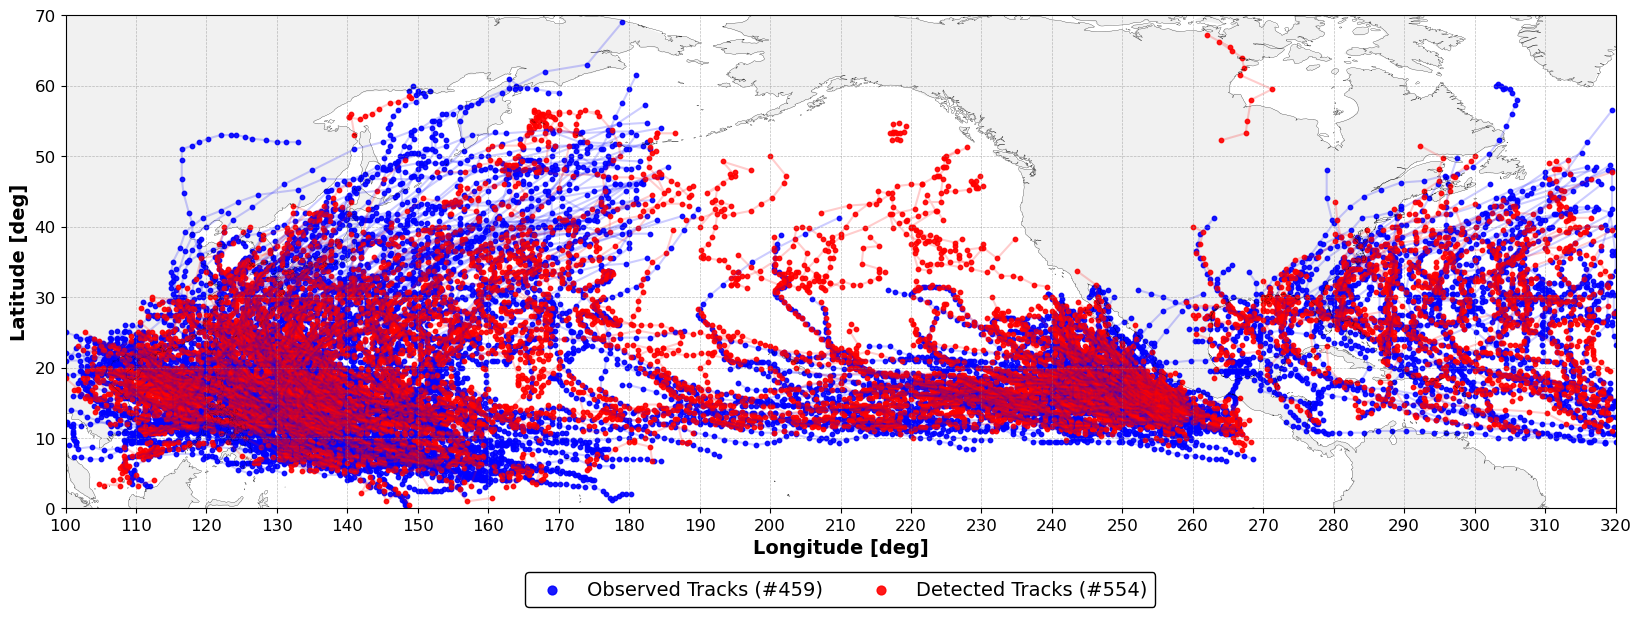

In [23]:
if plot:plot_tracks(detected_tracks, observed_tracks)

In [24]:
# if plot:plot_tracks(paper_detected_tracks, observed_tracks)

# Track Matching

In [25]:
max_track_distance = 300.0

In [26]:
track_matches = track_matching(detected_tracks, observed_tracks, max_track_distance)
track_matches

,OBS_TRACK_ID,DET_TRACK_ID
0,,19830521T18_1
1,1983141N07269,19830523T12_8
2,1983160N11266,19830613T00_4
3,1983167N05145,19830623T12_11
4,,19830705T00_5
...,...,...
574,2013251N13342,
575,2014080N08128,
576,1983271N12242,
577,1993205N15137,


In [27]:
# H = HITS = True Positive
H = len(track_matches[(track_matches['DET_TRACK_ID']!='') & (track_matches['OBS_TRACK_ID']!='')])
# M = Miss = False Negative
M = len(track_matches[(track_matches['DET_TRACK_ID']=='') & (track_matches['OBS_TRACK_ID']!='')])
# FA = False Alarm = False Positive
FA = len(track_matches[(track_matches['DET_TRACK_ID']!='') & (track_matches['OBS_TRACK_ID']=='')])

POD = (H / (H + M))
FAR = (FA / (H + FA))

print(f"POD : {POD}")
print(f"FAR : {FAR}")

POD : 0.7080610021786492
FAR : 0.2696629213483146


In [28]:
# sys.path.append('/Users/davide/Developer/ml-tropical-cyclones-detection/resources/library/dynamicopy-0.6.1')
# import dynamicopy

# columnsd = {'ISO_TIME': 'time','LAT':'lat','LON':'lon','TRACK_ID':'track_id','WS':'ws'}
# columns = list(columnsd.values())

# bobs = dynamicopy.load_ibtracs()
# bobs = bobs[bobs['basin'].isin(['WNP','ENP','NATL'])].reset_index(drop=True)

# dets = detected_tracks.rename(columns={'ISO_TIME':'time','LAT':'lat','LON':'lon','TRACK_ID':'track_id'})
# obss = observed_tracks.rename(columns={'ISO_TIME':'time','LAT':'lat','LON':'lon','TRACK_ID':'track_id'})

# dets['lon'] = (dets['lon'] + 540) % 360 - 180
# obss['lon'] = (obss['lon'] + 540) % 360 - 180
# bobs['lon'] = (bobs['lon'] + 540) % 360 - 180
# bobs = bobs[(bobs['lon']>=100) & (bobs['lon']<=320) & (bobs['lat']>=0) & (bobs['lat']<=70)]

# bobs = bobs[bobs['time'].isin(dates)]

# match = dynamicopy.match_tracks(dets, obss, "ours", "ib", max_dist=max_track_distance, min_overlap=0, ref=True)

# n_match = len(match['id_ib'].unique())
# n_observations = len(obss.track_id.unique())
# n_detections = len(dets.track_id.unique())

# POD = n_match / n_observations
# FAR = 1 - (n_match / n_detections)
# H, M, FA = n_match, (n_observations-n_match), n_detections - n_match

# # POD, FAR, H, M, FA
# print(f"POD : {POD}")
# print(f"FAR : {FAR}")

# match = dynamicopy.match_tracks(dets, bobs, "ours", "ib", max_dist=max_track_distance, min_overlap=0, ref=True)

# n_match = len(match['id_ib'].unique())
# n_observations = len(bobs.track_id.unique())
# n_detections = len(dets.track_id.unique())

# POD = n_match / n_observations
# FAR = 1 - (n_match / n_detections)
# H, M, FA = n_match, (n_observations-n_match), n_detections - n_match

# # POD, FAR, H, M, FA
# print(f"POD : {POD}")
# print(f"FAR : {FAR}")

# match = dynamicopy.match_tracks(obss[obss['NATURE'].isin(['TS','SS'])], bobs, "ours", "ib", max_dist=max_track_distance, min_overlap=0, ref=True)

# n_match = len(match['id_ib'].unique())
# n_observations = len(bobs.track_id.unique())
# n_detections = len(dets.track_id.unique())

# POD = n_match / n_observations
# FAR = 1 - (n_match / n_detections)
# H, M, FA = n_match, (n_observations-n_match), n_detections - n_match

# # POD, FAR, H, M, FA
# print(f"POD : {POD}")
# print(f"FAR : {FAR}")

# Paper Results

In the paper, with the ML ensemble we have the following results:

- F2-score : 53 %
- Euclidean distance : 117.06 km
- Hit rate : 88.91 %
- POD : 71.49 %
- FAR : 23.00 %